In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage import rotate
import cv2
from PIL import Image
from scipy.ndimage import zoom

In [2]:
Ci,Cf=0,255
Fi,Ff=0,255
PDith=4
Npixeles=256
z_FS=0.6
#z_SD=0.1922 #Dist1
#z_SD=0.6 #Dist2
z_SD=1.2 #Dist3
z_FD=z_FS+z_SD
M=z_FD/z_FS
a=10*(10**(-6))
W=55*(10**(-6))
Dx=2*W
E=23*(10**(3)) #28kVp
#E=27*(10**(3)) #38kVp
#E=30*(10**(3)) #48kVp
#E=35*(10**(3)) #58kVp
#E=37*(10**(3)) #68kVp
#E=39*(10**(3)) #78kVp
E_J=E*1.6*(10**(-19))
h=6.63*10**(-34)
c=3*(10**(8))
k=(2*np.pi*E_J)/(h*c)
o=k/z_SD
nameP="AngiografiaR"
nameI="EI"
nameV="28kVp"
nameF="FilterAl"
nameD="Dist3"
nameTP="PlaqueI"
nameGG="PData/RAWS.txt"
name0=nameP+"/"+nameI+"/"+nameV+"/"+nameF+"/"+nameD+"/"+nameTP+"/"
xL=np.arange(0,int(((Npixeles)/2)*PDith),90)
xJ = np.multiply(xL,np.round(2/PDith,1))
labelsx=xL.tolist()
labelsy=[int(i) for i in xJ]

In [3]:
def PhaseIntegrated(name,Dx):
    I=np.zeros((name.shape[0],name.shape[1]))
    for j in range(name.shape[1]):
        Int=0
        for i in range(j+1):
            Int=Int+name[:,i]*Dx
        I[:,j]=Int
    return I

In [36]:
def Wiener(name,W,Dx,vo,n,s):
    frr = np.fft.fftshift(np.fft.fft2(name))
    u=np.fft.fftshift(np.fft.fftfreq(name.shape[1], 2*W))
    v=np.fft.fftshift(np.fft.fftfreq(name.shape[0], W))
    uu, vv = np.meshgrid(u, v)
    SNR=s/(1+(vv/vo)**(2*n))
    D=-2j*np.sin(2*np.pi*Dx*uu)
    Dc=np.conj(D)
    DFrq=Dc/(D**2+(1/SNR))
    A=frr*DFrq
    A2=(np.fft.ifft2(np.fft.ifftshift(A)).real)*Dx
    return A2

In [6]:
def PI(name,inicial,final,h,y):
    P=np.zeros(y-h)
    for i in range(inicial,final):
        P=P+name[i,h:y]
    mean=P/(final-inicial)
    return mean

In [7]:
Dith=[]
for i in range(PDith):
    RAW=np.genfromtxt(name0+"Dt{}/".format(i)+nameGG)
    Dith.append(RAW)

In [8]:
ImPCYY=[]
ImPCYYY=[]
AbsYY=[]
PhaseDYY=[]
for i in range(PDith):
    ImPCYY.append(Dith[i][:,1::2])
    ImPCYYY.append(Dith[i][:,::2])
    AbsYY.append((Dith[i][:,::2]+Dith[i][:,1::2])/2)
    PhaseDYY.append(((M*a*o)/2)*((-Dith[i][:,::2]+Dith[i][:,1::2])/(Dith[i][:,::2]+Dith[i][:,1::2])))
#    PhaseYY.append(Wiener(PhaseYD,W,Dx,vvo,n,ss))
#    PhaseYY.append(PhaseIntegrated(PhaseYD,Dx))

In [9]:
ImPCDith=np.zeros((Npixeles,PDith*int(Npixeles/2)))
ImPCCDith=np.zeros((Npixeles,PDith*int(Npixeles/2)))
AbsDith=np.zeros((Npixeles,PDith*int(Npixeles/2)))
PhaseDDith=np.zeros((Npixeles,PDith*int(Npixeles/2)))
for i in range(PDith):
    for j in range(int(Npixeles/2)):
        ImPCDith[:,PDith*j+i:PDith*j+i+1]=ImPCYY[PDith-1-i][:,j:j+1]
        ImPCCDith[:,PDith*j+i:PDith*j+i+1]=ImPCYYY[PDith-1-i][:,j:j+1]
        AbsDith[:,PDith*j+i:PDith*j+i+1]=AbsYY[PDith-1-i][:,j:j+1]
        PhaseDDith[:,PDith*j+i:PDith*j+i+1]=PhaseDYY[PDith-1-i][:,j:j+1]
Factor = ImPCDith.shape[1] / ImPCDith.shape[0]
ImPCDithS= zoom(ImPCDith, (Factor, 1))
ImPCCDithS= zoom(ImPCCDith, (Factor, 1))
AbsDithS= zoom(AbsDith, (Factor, 1))
PhaseDDithS= zoom(PhaseDDith, (Factor, 1))

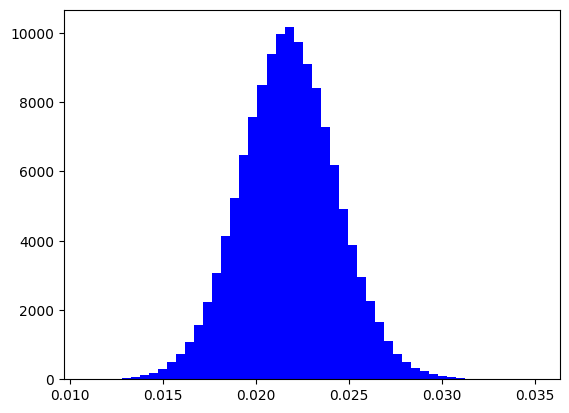

In [10]:
Phac=plt.hist(np.ravel(ImPCDith),bins=50,color="blue")

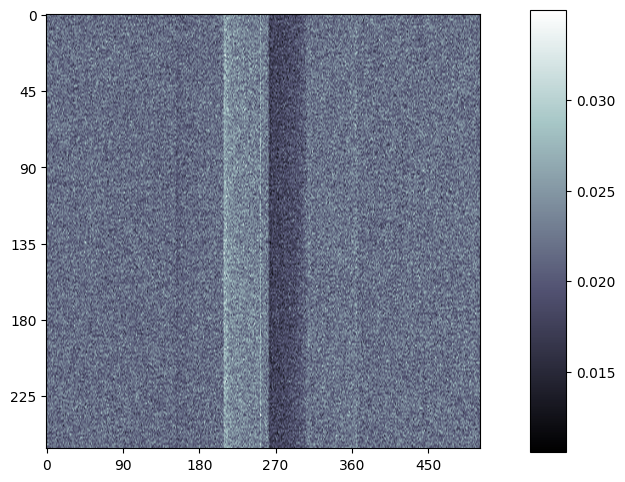

In [40]:
fig, ax = plt.subplots(figsize=(7, 7))
u=ax.imshow(ImPCDithS, cmap="bone")
plt.xticks(xL,labelsx)
plt.yticks(xL,labelsy)
fig.colorbar(u,ax=ax,location='right', anchor=(0.5, 0.5), shrink=0.82,aspect=12)
#plt.savefig(name0+"/PData/ICF.png", bbox_inches='tight', transparent=True, pad_inches=0,dpi=199)

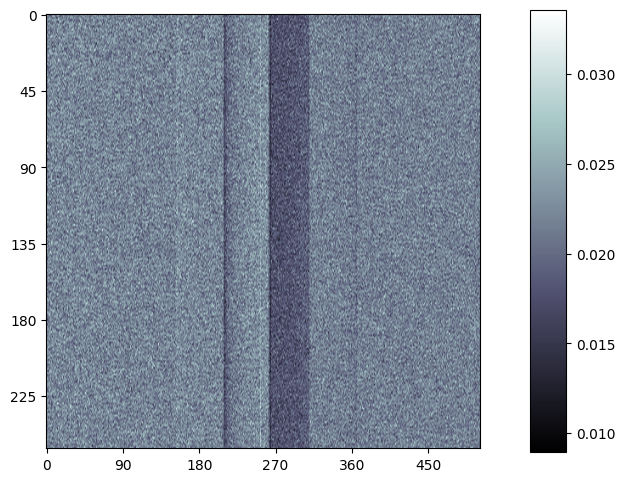

In [41]:
fig, ax = plt.subplots(figsize=(7, 7))
u=ax.imshow(ImPCCDithS, cmap="bone")
plt.xticks(xL,labelsx)
plt.yticks(xL,labelsy)
fig.colorbar(u,ax=ax,location='right', anchor=(0.5, 0.5), shrink=0.82,aspect=12)
#plt.savefig(name0+"/PData/ICCF.png", bbox_inches='tight', transparent=True, pad_inches=0,dpi=199)

In [13]:
PIPC=PI(ImPCDith,0,ImPCDith.shape[0],0,ImPCDith.shape[1])
PIPCC=PI(ImPCCDith,0,ImPCCDith.shape[0],0,ImPCCDith.shape[1])

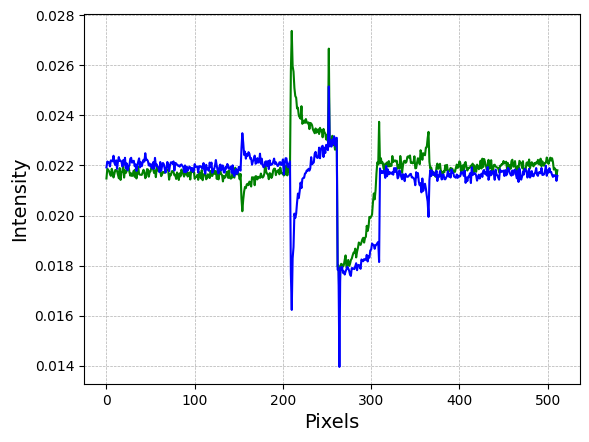

In [14]:
plt.plot(PIPC, '-', color="green")
plt.plot(PIPCC, '-', color="blue")
plt.xlabel("Pixels",fontsize=14)
plt.ylabel("Intensity",fontsize=14)
#plt.ylim(-390,10)
plt.grid(linestyle = '--', linewidth = 0.5)

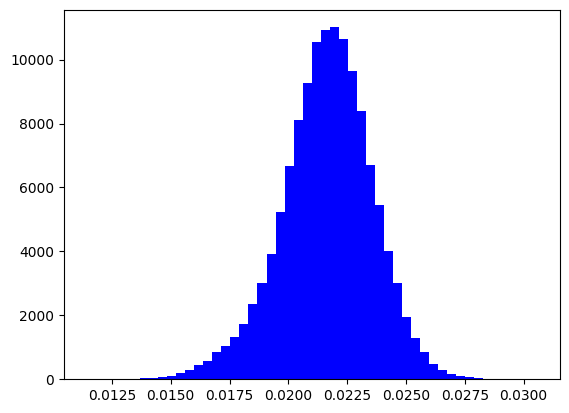

In [15]:
Phai=plt.hist(np.ravel(AbsDith),bins=50,color="blue")

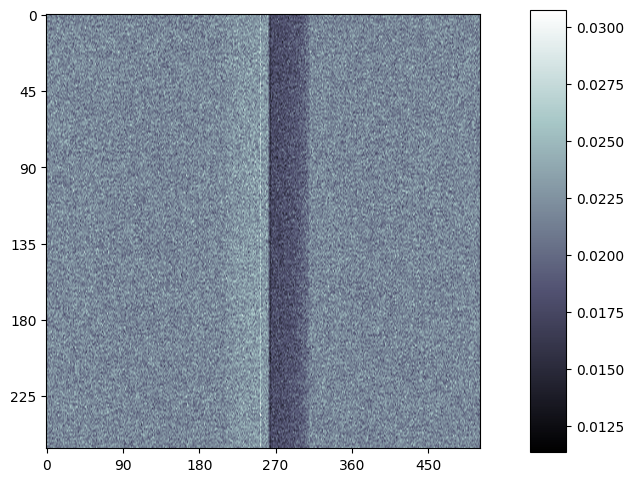

In [42]:
fig, ax = plt.subplots(figsize=(7, 7))
u=ax.imshow(AbsDithS, cmap="bone")
plt.xticks(xL,labelsx)
plt.yticks(xL,labelsy)
fig.colorbar(u,ax=ax,location='right', anchor=(0.5, 0.5), shrink=0.82,aspect=12)
#plt.savefig(name0+"/PData/Abs.png", bbox_inches='tight', transparent=True, pad_inches=0,dpi=199)

In [17]:
PIAbs=PI(AbsDith,0,AbsDith.shape[0],0,AbsDith.shape[1])

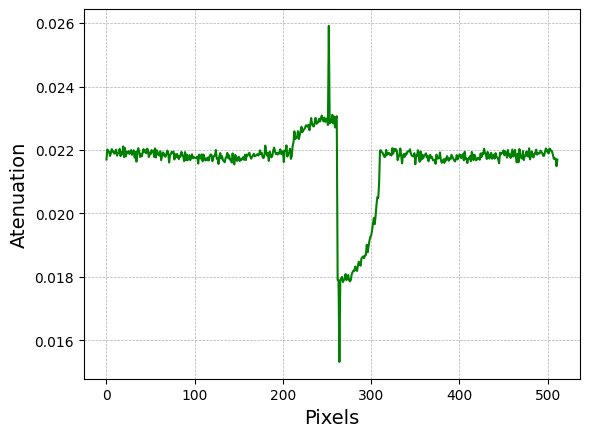

In [18]:
plt.plot(PIAbs, '-', color="green")
plt.xlabel("Pixels",fontsize=14)
plt.ylabel("Atenuation",fontsize=14)
#plt.ylim(-390,10)
plt.grid(linestyle = '--', linewidth = 0.5)

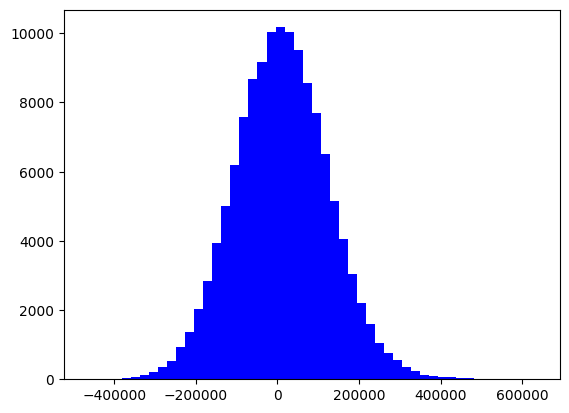

In [19]:
Phap=plt.hist(np.ravel(PhaseDDith),bins=50,color="blue")

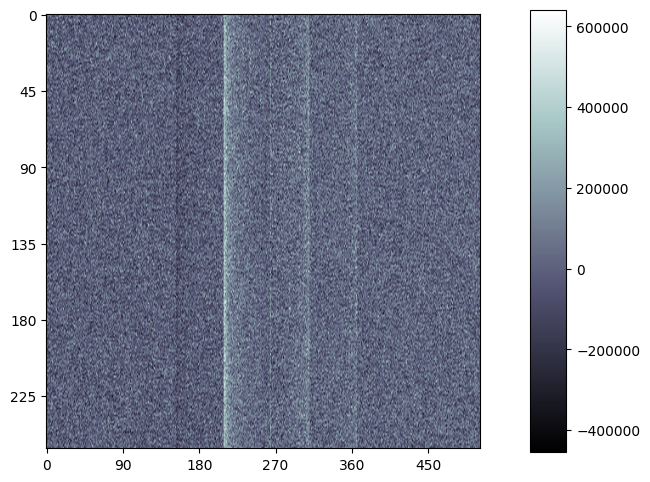

In [43]:
fig, ax = plt.subplots(figsize=(7, 7))
u=ax.imshow(PhaseDDithS, cmap="bone")
plt.xticks(xL,labelsx)
plt.yticks(xL,labelsy)
fig.colorbar(u,ax=ax,location='right', anchor=(0.5, 0.5), shrink=0.82,aspect=12)
#plt.savefig(name0+"/PData/PhD.png", bbox_inches='tight', transparent=True, pad_inches=0,dpi=199)

In [21]:
PIPhD=PI(PhaseDDith,0,PhaseDDith.shape[0],0,PhaseDDith.shape[1])

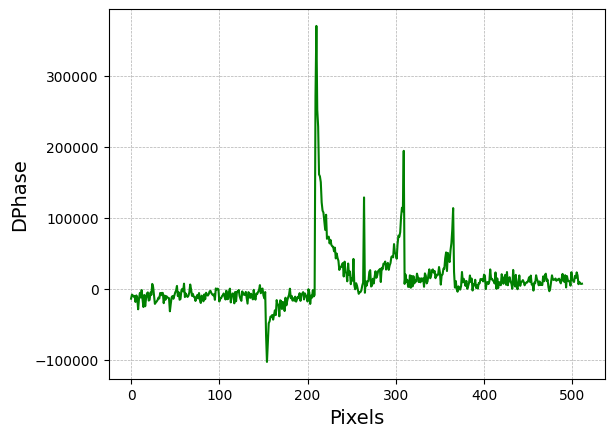

In [22]:
plt.plot(PIPhD, '-', color="green")
plt.xlabel("Pixels",fontsize=14)
plt.ylabel("DPhase",fontsize=14)
#plt.ylim(-390,10)
plt.grid(linestyle = '--', linewidth = 0.5)

In [23]:
PhaseI=PhaseIntegrated(PhaseDDith,Dx)
PhaseIS= zoom(PhaseI, (Factor, 1))

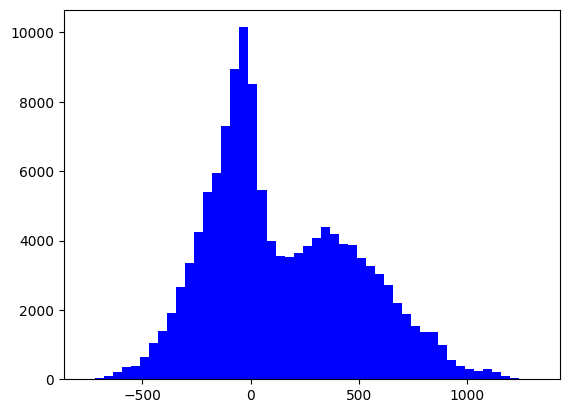

In [24]:
PhapI=plt.hist(np.ravel(PhaseI),bins=50,color="blue")

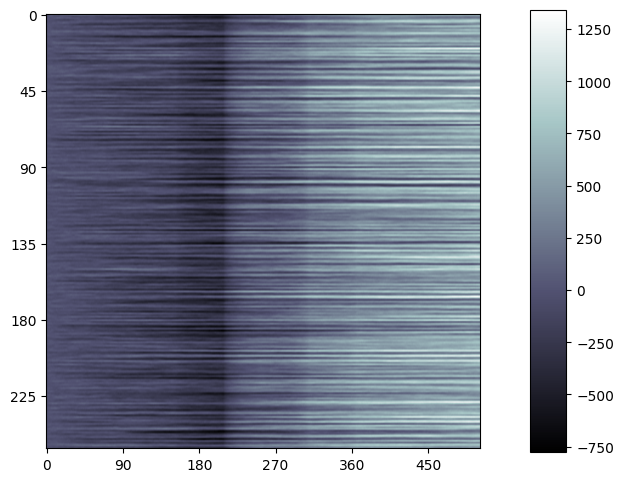

In [44]:
fig, ax = plt.subplots(figsize=(7, 7))
u=ax.imshow(PhaseIS, cmap="bone")
plt.xticks(xL,labelsx)
plt.yticks(xL,labelsy)
fig.colorbar(u,ax=ax,location='right', anchor=(0.5, 0.5), shrink=0.82,aspect=12)
#plt.savefig(name0+"/PData/PhI.png", bbox_inches='tight', transparent=True, pad_inches=0,dpi=199)

In [37]:
vo=6*(10**(3))
s=2*(10**(6))
n=1
PhaseJ=Wiener(PhaseDDith,W,Dx,vo,n,s)
PhaseJS= zoom(PhaseJ, (Factor, 1))

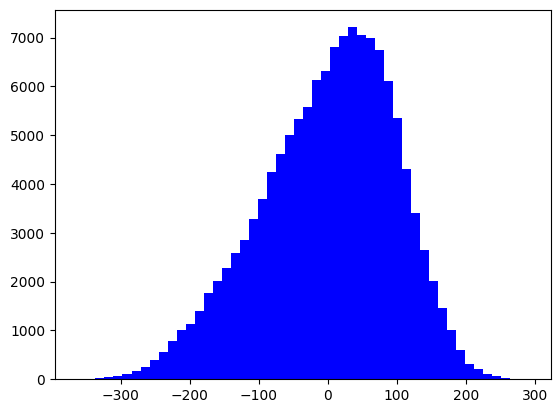

In [38]:
PhapJ=plt.hist(np.ravel(PhaseJ),bins=50,color="blue")

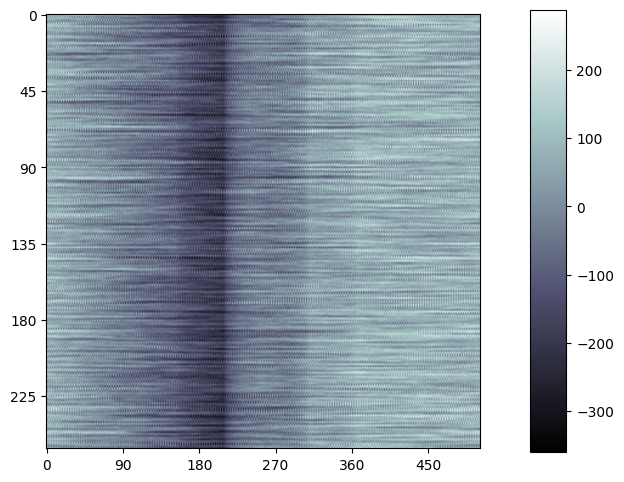

In [45]:
fig, ax = plt.subplots(figsize=(7, 7))
u=ax.imshow(PhaseJS, cmap="bone")
plt.xticks(xL,labelsx)
plt.yticks(xL,labelsy)
fig.colorbar(u,ax=ax,location='right', anchor=(0.5, 0.5), shrink=0.82,aspect=12)
#plt.savefig(name0+"/PData/PhW.png", bbox_inches='tight', transparent=True, pad_inches=0,dpi=199)

In [29]:
PIPhW=PI(PhaseJ,0,PhaseJ.shape[0],0,PhaseJ.shape[1])

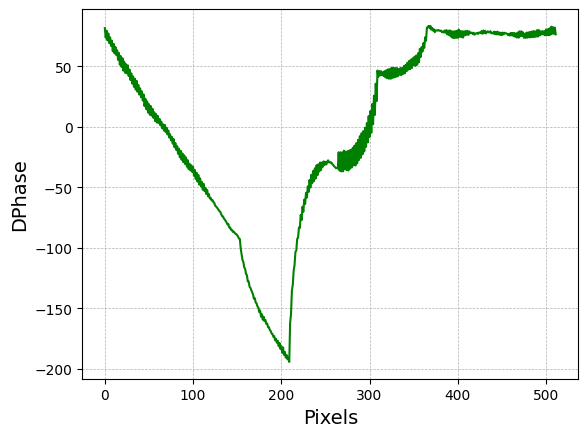

In [30]:
plt.plot(PIPhW, '-', color="green")
plt.xlabel("Pixels",fontsize=14)
plt.ylabel("DPhase",fontsize=14)
#plt.ylim(-390,10)
plt.grid(linestyle = '--', linewidth = 0.5)

In [31]:
#np.savetxt(name0+"\PData\IPCW.txt",ImPCDith)
#np.savetxt(name0+"\PData\IPCCW.txt",ImPCCDith)
#np.savetxt(name0+"\PData\PIPCW.txt",PIPC)
#np.savetxt(name0+"\PData\PIPCCW.txt",PIPCC)
#np.savetxt(name0+"\PData\IPCPlusW.txt",AbsDith)
#np.savetxt(name0+"\PData\PICPlusW.txt",PIAbs)
#np.savetxt(name0+"\PData\PIPhDW.txt",PIPhD)
####################################################
#np.savetxt(name0+"\PData\IPC.txt",ImPCDith)
#np.savetxt(name0+"\PData\IPCC.txt",ImPCCDith)
#np.savetxt(name0+"\PData\PIPC.txt",PIPC)
#np.savetxt(name0+"\PData\PIPCC.txt",PIPCC)
#np.savetxt(name0+"\PData\Abs.txt",AbsDith)
#np.savetxt(name0+"\PData\PIAbs.txt",PIAbs)
#np.savetxt(name0+"\PData\PhD.txt",PhaseDDith)
#np.savetxt(name0+"\PData\PIPhD.txt",PIPhD)
#np.savetxt(name0+"\PData\PhW.txt",PhaseJ)
#np.savetxt(name0+"\PData\PIPhW.txt",PIPhW)